In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import hist
from hist import Hist
from coffea.nanoevents import NanoEventsFactory, BaseSchema
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, schemas
import numpy as np

In [2]:
fileset = "/eos/home-b/bchitrod/HHH/NANOAOD/TRSM_XToHY_6b_M3_2000_M2_1100_NANOAOD.root" 

In [3]:
eventsToRead = 10000
events = NanoEventsFactory.from_root(fileset,schemaclass=NanoAODSchema,metadata={"dataset": "testSignal"},entry_stop=eventsToRead).events()

In [7]:
fatjets = events.FatJet
jets = events.Jet
boosted_cutflow = []
semiboosted_cutflow = []

all_events = ak.size(fatjets, axis=0)
boosted_cutflow.append(all_events)
semiboosted_cutflow.append(all_events)

print("all events = ",all_events)
##FatJet cuts
ptcut = 250
etacut = 2.5
mass_mincut = 110
mass_maxcut = 140
pNet_cut = 0.9105

good_fatjets = fatjets[(fatjets.pt>ptcut) & (np.absolute(fatjets.eta)<etacut)]
good_boosted = good_fatjets[ak.num(good_fatjets, axis=1) >= 3]
good_semiboosted = good_fatjets[ak.num(good_fatjets, axis=1) == 2]     
boosted_cutflow.append(ak.size(good_boosted, axis=0))
semiboosted_cutflow.append(ak.size(good_semiboosted, axis=0))
        

mass_fatjets = good_fatjets[(good_fatjets.msoftdrop>=mass_mincut) & (good_fatjets.msoftdrop<=mass_maxcut)]
mass_boosted = mass_fatjets[ak.num(mass_fatjets, axis=1) >= 3]
mass_semiboosted = mass_fatjets[ak.num(mass_fatjets, axis=1) == 2] 
boosted_cutflow.append(ak.size(mass_boosted, axis=0))
semiboosted_cutflow.append(ak.size(mass_semiboosted, axis=0))

## Resolved Jet cuts
res_ptcut = 30
res_etacut = 2.5
res_mass_mincut = 90
res_mass_maxcut = 140
# loose cut = 0.0532, med_cut = 0.3040, tight_cut = 0.7476 , https://twiki.cern.ch/twiki/bin/view/CMS/BtagRecommendation106XUL17
res_deepBcut = 0.0532

good_jets = jets[(jets.pt > res_ptcut) & (np.absolute(jets.eta) < res_etacut)]

res_jets = (good_jets[ak.num(mass_fatjets, axis=1) == 2])

good_pairs = res_jets.nearest(mass_semiboosted).delta_r(res_jets)>0.8
good_paired = res_jets[good_pairs]
res_bjets = (good_paired[ak.num(good_paired, axis=1) >= 2])
semiboosted_cutflow.append(ak.size(res_bjets, axis=0))

all events =  10000


In [8]:
mass = (res_bjets[:,0]+res_bjets[:,1]).mass

mass_bjets = res_bjets[((res_bjets[:,0]+res_bjets[:,1]).mass>=res_mass_mincut) &  ((res_bjets[:,0]+res_bjets[:,1]).mass<=res_mass_maxcut)]
semiboosted_cutflow.append(ak.size(mass_bjets, axis=0))

btag_fatjets = mass_fatjets[(mass_fatjets.particleNet_HbbvsQCD>=pNet_cut)]
btag_boosted = btag_fatjets[ak.num(btag_fatjets, axis=1) >= 3]
boosted_cutflow.append(ak.size(btag_boosted, axis=0))

selected_fatjets = mass_fatjets[ak.num(mass_bjets,axis=1)>1]
btagged_fatjets = selected_fatjets[(selected_fatjets.particleNet_HbbvsQCD>=pNet_cut)]
btag_semiboosted = btagged_fatjets[ak.num(btagged_fatjets, axis=1) == 2]
semiboosted_cutflow.append(ak.size(btag_semiboosted, axis=0))

selected_jets = mass_bjets[ak.num(btagged_fatjets, axis=1) == 2]
btag_jets = selected_jets[((selected_jets[:,0].btagDeepB)>res_deepBcut) & ((selected_jets[:,1].btagDeepB)>res_deepBcut)]
semiboosted_cutflow.append(ak.size(btag_jets, axis=0))

print(boosted_cutflow)
print(semiboosted_cutflow)


[10000, 6073, 427, 337]
[10000, 3598, 2351, 2089, 532, 126, 107]


In [14]:

nb = [0,1,2,3]
ns = [0,1,2,3,4,5,6]

In [15]:
boosted_bin = hist.axis.Regular(label="Boosted cutflow", name="boosted_cf", bins=105, start=0, stop=10500)
n_bin = hist.axis.Regular(label="Cuts", name="cuts", bins=5, start=0, stop=5)

In [16]:
boosted_hist = Hist(n_bin, boosted_bin)

In [17]:
boosted_hist.fill(cuts=nb, boosted_cf=boosted_cutflow)

Hist(
  Regular(5, 0, 5, name='cuts', label='Cuts'),
  Regular(105, 0, 10500, name='boosted_cf', label='Boosted cutflow'),
  storage=Double()) # Sum: 4.0

In [18]:
def label_densityHist(ax, n, bins, x=4, y=99.1, r=2, **kwargs):


    k = []
    # calculate the relative frequency of each bin
    for i in range(0,len(n)):
        k.append(n[i])

    
    print(k)
    print(n)
    print(len(n))
    # plot the label/text to each bin
    for i in range(0, len(n)):
        #x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        x_pos = bins[i]
        y_pos = n[i] + y
        label = str(k[i]) # relative frequency of each bin
        ax.text(x_pos, y_pos, label, kwargs)

No handles with labels found to put in legend.


[10000, 6073, 427, 337]
[10000, 6073, 427, 337]
4


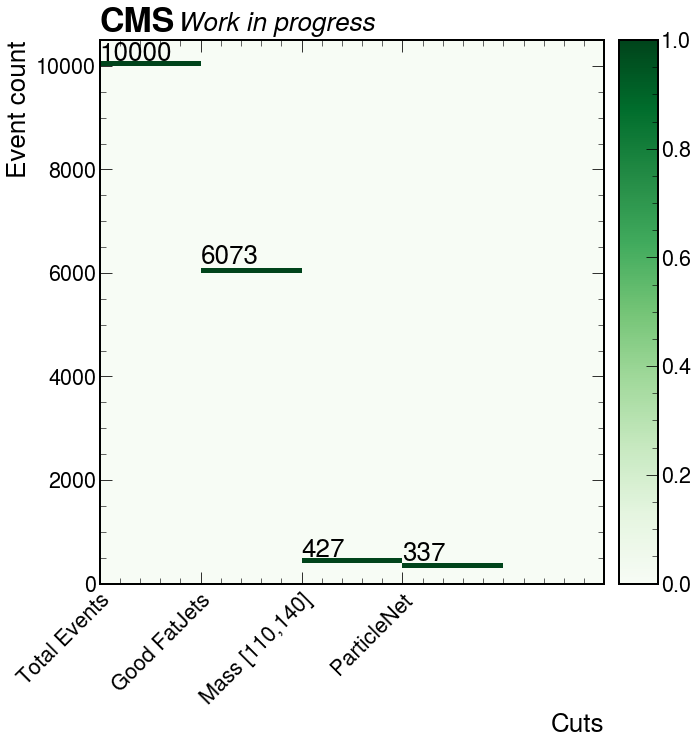

In [33]:
import mplhep as hep
from matplotlib import colors
f, ax = plt.subplots()
axe=plt.gca()
plt.style.use([hep.style.CMS])
label_densityHist(axe,boosted_cutflow,nb)
boosted_hist.plot(cmap="Greens")
xLabels=["Total Events","Good FatJets","Mass [110,140]","ParticleNet"]
xTicks=nb
ax.set_xticks(xTicks)
ax.set_xticklabels(xLabels,rotation=45, rotation_mode="anchor", ha="right")
hep.cms.text("Work in progress",loc=0)
plt.ylabel("Event count",horizontalalignment='right', y=1.0)
plt.legend()


In [20]:
semiboosted_bin = hist.axis.Regular(label="semiboosted cutflow", name="semib_cf", bins=105, start=0, stop=10500)
n_bin = hist.axis.Regular(label="Cuts", name="cuts", bins=7, start=0, stop=7)

In [21]:
semiboosted_hist = Hist(n_bin, semiboosted_bin)
semiboosted_hist.fill(cuts=ns, semib_cf=semiboosted_cutflow)

Hist(
  Regular(7, 0, 7, name='cuts', label='Cuts'),
  Regular(105, 0, 10500, name='semib_cf', label='semiboosted cutflow'),
  storage=Double()) # Sum: 7.0

[10000, 3598, 2351, 2089, 532, 126, 107]
[10000, 3598, 2351, 2089, 532, 126, 107]
7


No handles with labels found to put in legend.


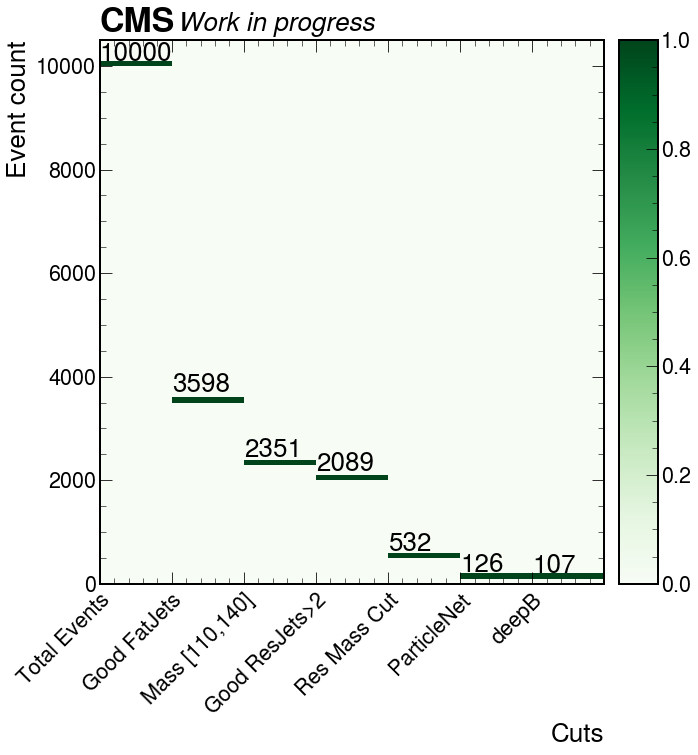

In [29]:

plt.style.use([hep.style.CMS])
f, ax = plt.subplots()
axe=plt.gca()
plt.style.use([hep.style.CMS])
label_densityHist(axe,semiboosted_cutflow,ns)
semiboosted_hist.plot(cmap="Greens")
xLabels=["Total Events","Good FatJets","Mass [110,140]","Good ResJets>2","Res Mass Cut","ParticleNet","deepB"]
xTicks=ns
ax.set_xticks(xTicks)
ax.set_xticklabels(xLabels,rotation=45, rotation_mode="anchor", ha="right")
hep.cms.text("Work in progress",loc=0)
plt.ylabel("Event count",horizontalalignment='right', y=1.0)
plt.legend()

In [30]:
j_bin = hist.axis.Regular(label="Resolved Jet Mass [GeV]", name="resjet_mass", bins=40, start=0, stop=400)
j_cat = hist.axis.StrCategory(label='Resjets', name='resjet', categories=["signal"])#can add bkg categories later on

In [31]:
j_hist = Hist(j_bin, j_cat)
j_hist.fill(resjet="signal", resjet_mass=mass)

Hist(
  Regular(40, 0, 400, name='resjet_mass', label='Resolved Jet Mass [GeV]'),
  StrCategory(['signal'], name='resjet', label='Resjets'),
  storage=Double()) # Sum: 1283.0 (2089.0 with flow)

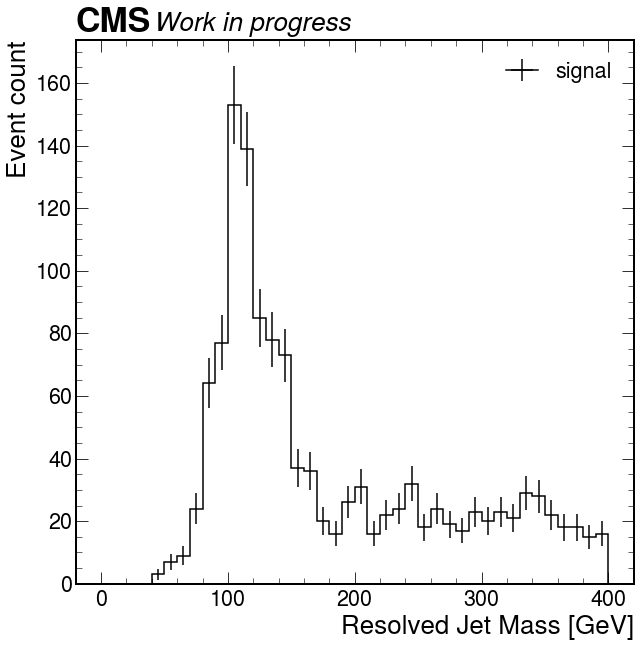

In [32]:
import mplhep as hep
plt.style.use([hep.style.CMS])
j_hist.plot(color="black")
hep.cms.text("Work in progress",loc=0)
plt.ylabel("Event count",horizontalalignment='right', y=1.0)
plt.legend()